In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


In [31]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [17]:
data = pd.read_csv('../input/fer2013/fer2013.csv')

In [18]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [19]:
x_data = data['pixels']
y_data = data['emotion']

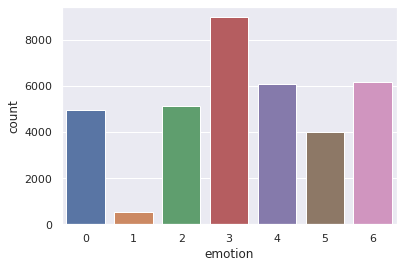

In [20]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [21]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [22]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [23]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    17 13 38 148 166 155 161 154 124 68 45 64 85 7...
62919    94 127 153 193 201 201 205 211 216 218 222 223...
62920    51 56 44 46 60 56 40 40 42 33 48 68 65 88 100 ...
62921    214 218 240 254 255 254 255 252 198 132 117 12...
62922    43 43 38 34 33 33 34 33 30 30 30 30 30 30 30 3...
Length: 62923, dtype: object

In [24]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [25]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [26]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [32]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Reshape((-1,128)),
    Bidirectional(LSTM(128)),
#     (Reshape((-1,64))),
#     LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

2022-12-02 11:38:43.700636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:43.851897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:43.852784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:43.857312: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 64)        0

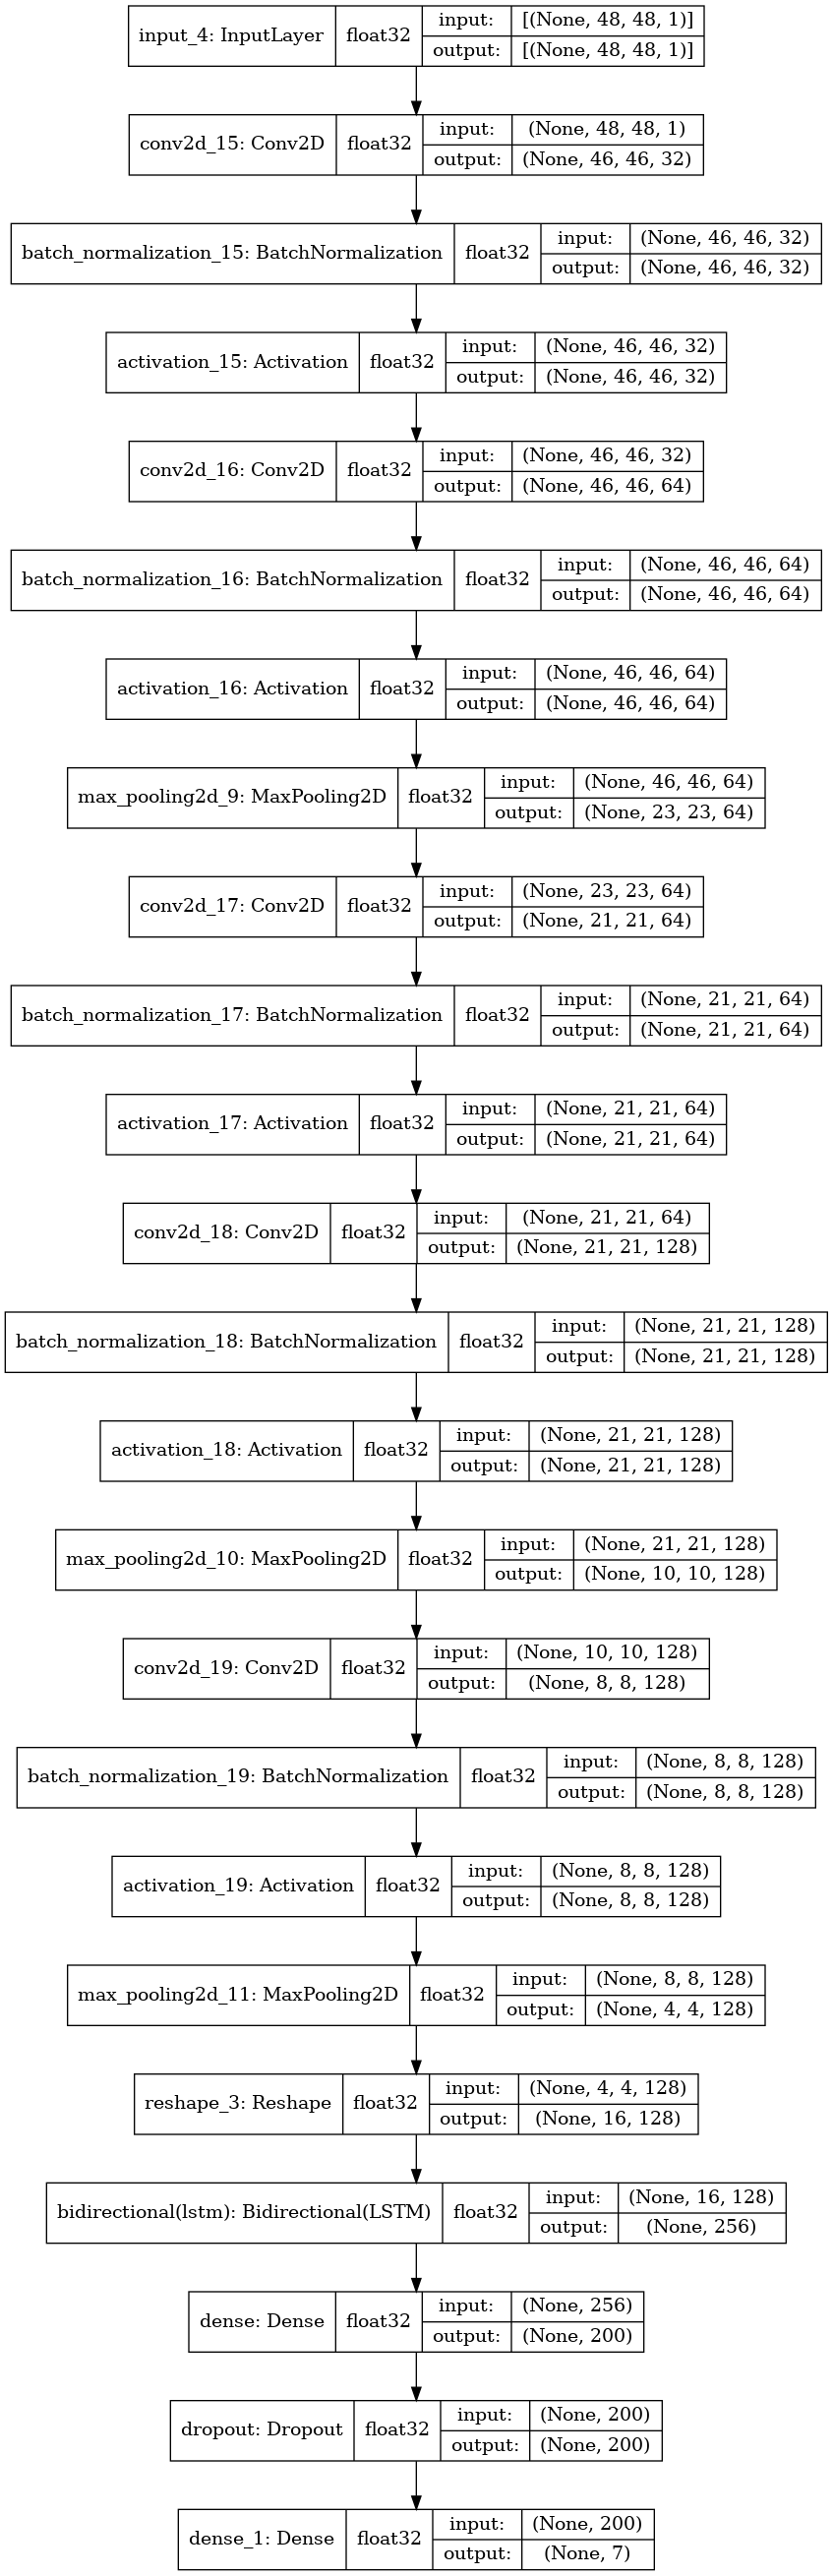

In [33]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [37]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [38]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [39]:
history = model.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

2022-12-02 11:39:07.962266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-02 11:39:11.720173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1770/1770 [==============================] - 31s 12ms/step - loss: 1.5599 - accuracy: 0.3960 - val_loss: 1.3649 - val_accuracy: 0.4759
Epoch 2/30
1770/1770 [==============================] - 20s 11ms/step - loss: 1.1319 - accuracy: 0.5683 - val_loss: 1.0753 - val_accuracy: 0.5967
Epoch 3/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.9583 - accuracy: 0.6390 - val_loss: 0.9722 - val_accuracy: 0.6232
Epoch 4/30
1770/1770 [==============================] - 20s 11ms/step - loss: 0.8364 - accuracy: 0.6912 - val_loss: 0.8932 - val_accuracy: 0.6560
Epoch 5/30
1770/1770 [==============================] - 20s 11ms/step - loss: 0.7188 - accuracy: 0.7390 - val_loss: 1.0465 - val_accuracy: 0.6159
Epoch 6/30
1770/1770 [==============================] - 20s 12ms/step - loss: 0.6082 - accuracy: 0.7833 - val_loss: 0.8779 - val_accuracy: 0.6898
Epoch 7/30
1770/1770 [==============================] - 20s 11ms/step - loss: 0.5167 - accuracy: 0.8197 - val_loss: 0.8392 - val_accura

In [40]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 1s 5ms/step - loss: 1.0643 - accuracy: 0.7998
Accuracy of our model on validation data :  79.97775077819824 %


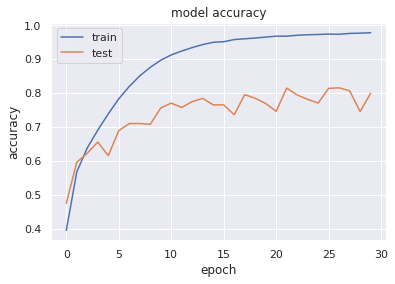

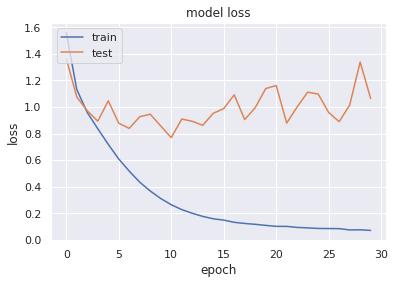

<Figure size 432x288 with 0 Axes>

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("model_acc")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("model_loss")

In [42]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[6, 5, 5, 4, 1, 0, 6, 4, 1, 4]

In [43]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       935
           1       0.99      1.00      0.99       895
           2       0.77      0.77      0.77       880
           3       0.88      0.73      0.80       906
           4       0.55      0.85      0.67       888
           5       0.96      0.86      0.91       869
           6       0.83      0.58      0.69       920

    accuracy                           0.80      6293
   macro avg       0.83      0.80      0.80      6293
weighted avg       0.83      0.80      0.80      6293



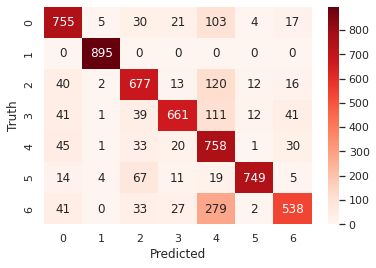

In [51]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (6,4))
sn.heatmap(cm,cmap="Reds", annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig("confusion")

In [ ]:
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save("model.h5") 